In [1]:
import os
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

plt.ion()   # interactive mode

In [2]:
class ControlsDataset(Dataset):
    """Dataset that maps camera images into steering angle"""
    def __init__(self, stack_size = 1 ,img_folder = 'data/', csv_path='data/data.csv'):
        self.stack_size = stack_size
        self.img_folder = img_folder
        # index_col = 0 so panda does not choose its own indexing
        self.data_frame = pd.read_csv(csv_path, index_col = 0)
            
    def __len__(self):
        return len(self.data_frame) - self.stack_size
    
    def __getitem__(self, idx):
        img_filenames = ["{0}{1:06d}.jpg".format(self.img_folder, i) 
                            for i in range(idx, idx+self.stack_size)]
        imgs = [io.imread(img_filename).transpose((2,0,1)) for img_filename in img_filenames]
        img_stack = np.concatenate(imgs, axis=0)
        
        # use the latest image as the control
        control = self.data_frame.iloc[idx+self.stack_size,0]
        control = np.array([control])
        
        sample = {'image': img_stack, 
                  'control': control}
        
        return sample

In [5]:
dataset = ControlsDataset(stack_size = 5)
dataloader = DataLoader(dataset, batch_size = 4, shuffle = True, num_workers = 0)

dataset[0]['image'].shape

(15, 480, 640)

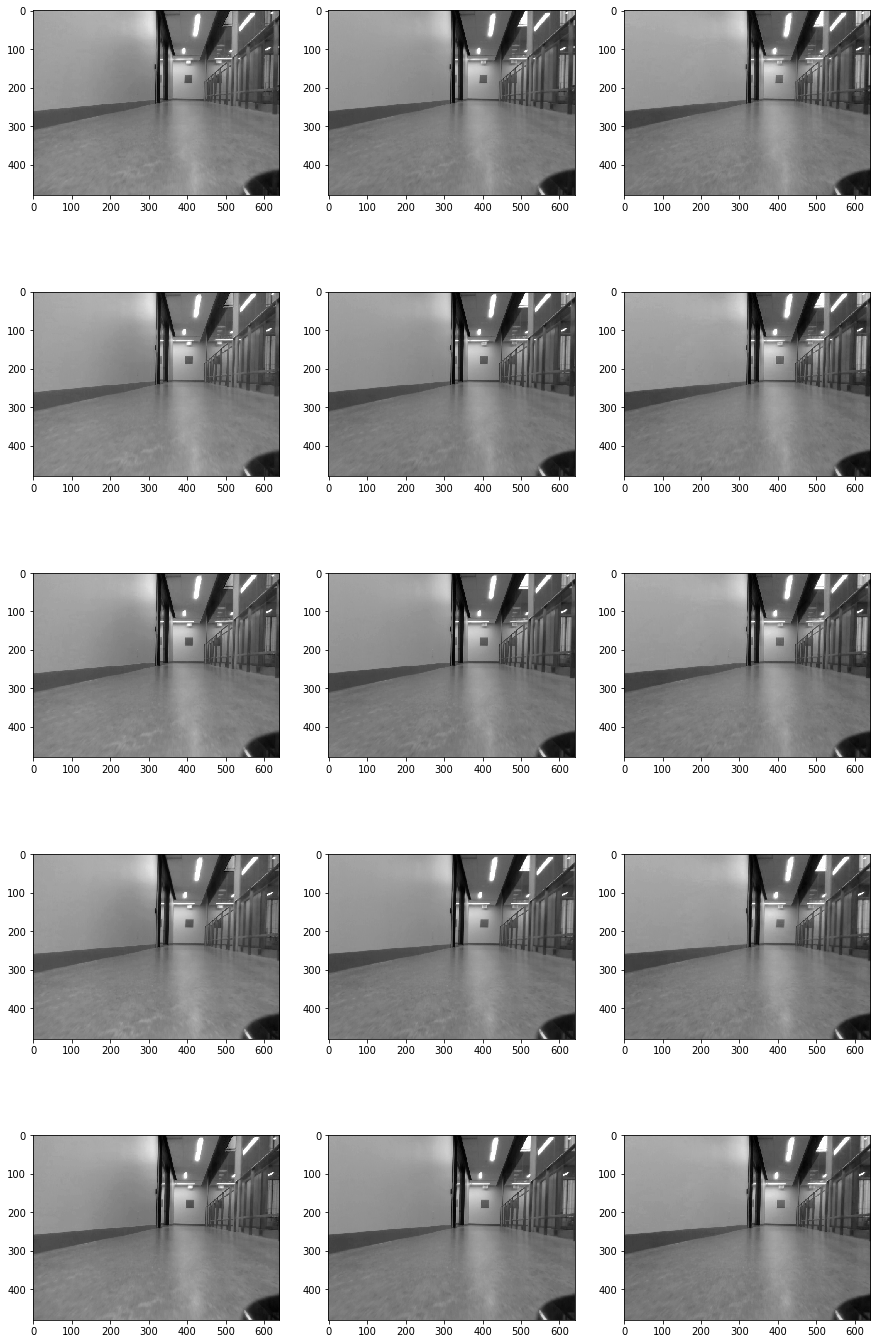

In [4]:
img_stack = dataset[100]['image']

f, ax = plt.subplots(5, 3, figsize=(15,25))
for k in range(15):
    i,j = k//3, k % 3
    ax[i,j].imshow(img_stack[k],cmap='gray')